In [22]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.wcs import WCS
from astropy.modeling import models
# specutils packages
from specutils import Spectrum1D
from specutils.analysis import line_flux
from specutils.fitting import fit_generic_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import centroid
from specutils.analysis import moment
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_threshold
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi
import warnings
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f5eede07880>

In [23]:
def closest(lst, K):
    '''find the closest number'''
    lst = np.array(lst)
    idx = (np.abs(lst - K)).argmin()
    return lst[idx]

In [24]:
def find_line(wl_vacuum, spec):
    '''
    This function find the line
    in a wavelenght range
    '''
    line_region = SpectralRegion((wl_vacuum-50)*u.AA, (wl_vacuum+50)*u.AA)
    line_spec = extract_region(spec, line_region)
    with warnings.catch_warnings():  # Ignore warnings
        warnings.simplefilter('ignore')
        line_spec = find_lines_threshold(line_spec, noise_factor = 3) # find the lines
        print("Number of line found:", len(line_spec))
    if len(line_spec) > 1:
        wl_line = closest(line_spec['line_center'].value, wl_vacuum)
        mask = line_spec['line_center'].value == wl_line
        line_spec_mask = line_spec[mask]
    else:
        line_spec_mask = line_spec
    return line_spec_mask

In [49]:
def errcont(wl_vacuum, spec):
    '''
    Find mean standar deviation both side of the line, and number of pixel cover for the 
    line
    '''
    line_spec_mask = find_line(wl_vacuum,  spec)
    min_lamb = line_spec_mask['line_center'] - 3.5 * u.AA
    max_lamb = line_spec_mask['line_center'] + 3.5 * u.AA
    sub_region_int = SpectralRegion(min_lamb, max_lamb)
    sub_spect_int = extract_region(spec, sub_region_int)
    line_para_line = estimate_line_parameters(sub_spect_int, models.Gaussian1D())
    sub_spectrum_line = extract_region(spec, sub_region_int)
    fwhm_ = gaussian_fwhm(sub_spectrum_line)
    min_lamb_ = line_para_line.mean.value - fwhm_.value / 2.
    max_lamb_ = line_para_line.mean.value + fwhm_.value / 2.
    sub_region_line_ = SpectralRegion(min_lamb_* u.AA,  max_lamb_* u.AA)
    sub_line_ = extract_region(spec, sub_region_line_)
    n_pixel = len(sub_line_.spectral_axis)
    print("Number of pixels:", n_pixel)
    # Determinante the median desviation standar in both side of the line
    min_lamb_cont = line_para_line.mean.value - fwhm_.value
    max_lamb_cont = line_para_line.mean.value + fwhm_.value
    min_lamb_cont_ = min_lamb_cont - 20
    max_lamb_cont_ = max_lamb_cont + 20
    sub_region_cont_left = SpectralRegion(min_lamb_cont_ * u.AA, min_lamb_cont * u.AA) # extract spec on left side of the line
    sub_region_cont_right = SpectralRegion(max_lamb_cont * u.AA, max_lamb_cont_ * u.AA) # extract spec on right side of the line
    sub_cont_left =  extract_region(spec, sub_region_cont_left)
    sub_cont_right =  extract_region(spec, sub_region_cont_right)
    #Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.plot(spec.spectral_axis, spec.flux, linewidth=10, c = "blueviolet", label = "J020808.63+491401.0")
    plt.plot(sub_cont_left.spectral_axis, sub_cont_left.flux, linewidth=10, c = "orange", linestyle='dashed', label = "Left")
    plt.plot(sub_cont_right.spectral_axis, sub_cont_right.flux, linewidth=10, c = "orange", linestyle='dashed', label = "Right")
    plt.xlabel('Wavelength $(\AA)$')
    plt.ylim(-100, (sub_spectrum_line.max() + 500*rel_flux))
    plt.xlim((line_spec_mask['line_center'].value-15), (line_spec_mask['line_center'].value+15))
    bbox_props = dict(boxstyle="round", fc="w", ec="0.88", alpha=0.6, pad=0.1)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    plt.close()
    

In [50]:
# OUR PN
hdu = fits.open("../Spectra-lamostdr7/spec-56581-VB031N50V1_sp08-218.fits")
hdudata = hdu[0].data
wl = hdudata[2]
Flux = hdudata[0]

In [51]:
# Defining units astropy
rel_flux = u.def_unit('Relative~flux')
rel_flux.decompose()

Unit("Relative~flux")

In [52]:
lamb = wl * u.AA 
flux = Flux * rel_flux
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

In [53]:
lines = {"[NeIII]+H7": 3967.470,
         "Hdelta": 4101.742,
         "Hgamma": 4340.471,
         "HeII": 4685.99,
         "Hbeta": 4861.333,
         "[OIII]4958": 4958.911,
         "[OIII]5006": 5006.843,
         "[FeIII]": 5412.12,
         "Halpha": 6564.614,
         }

Number of line found: 27
Number of pixels: 4


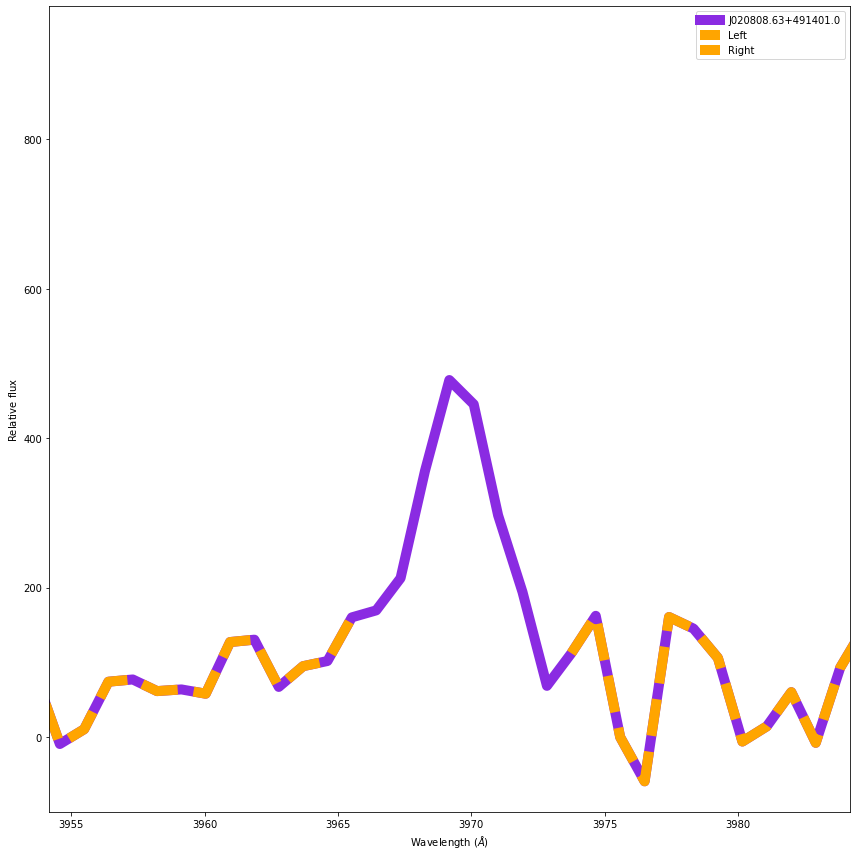

Number of line found: 11
Number of pixels: 3


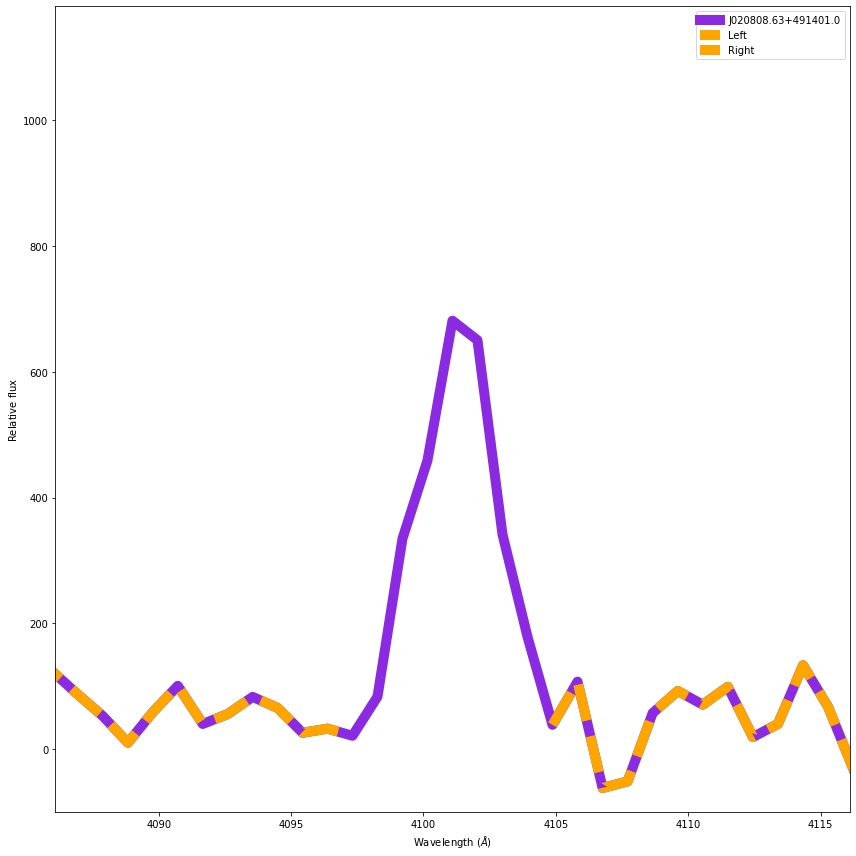

Number of line found: 9
Number of pixels: 3


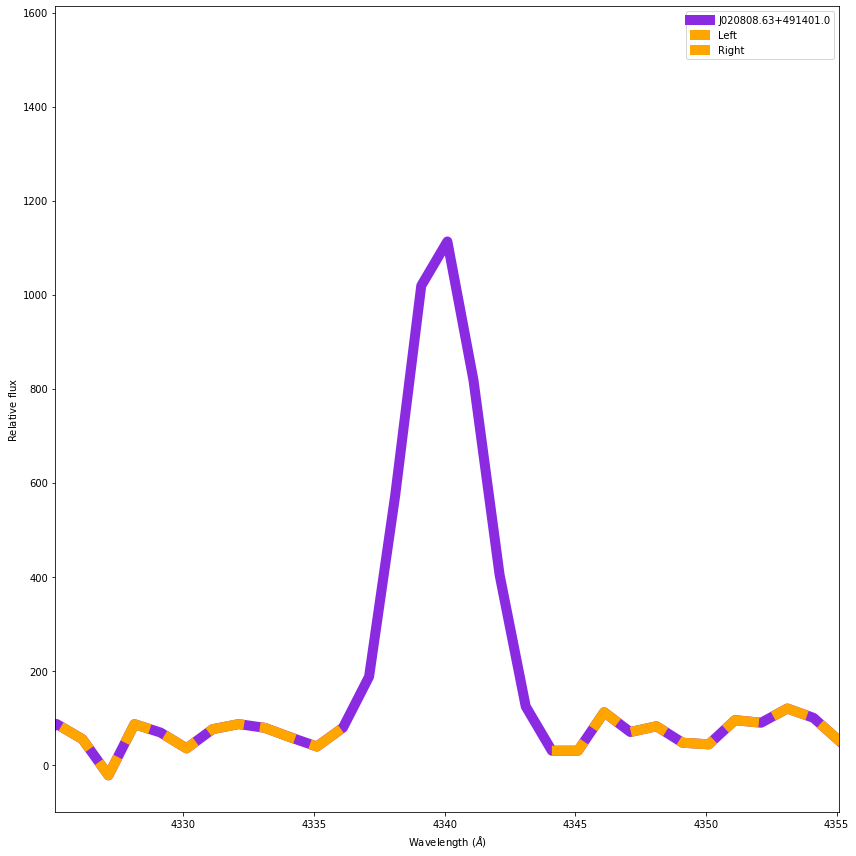

Number of line found: 1
Number of pixels: 3


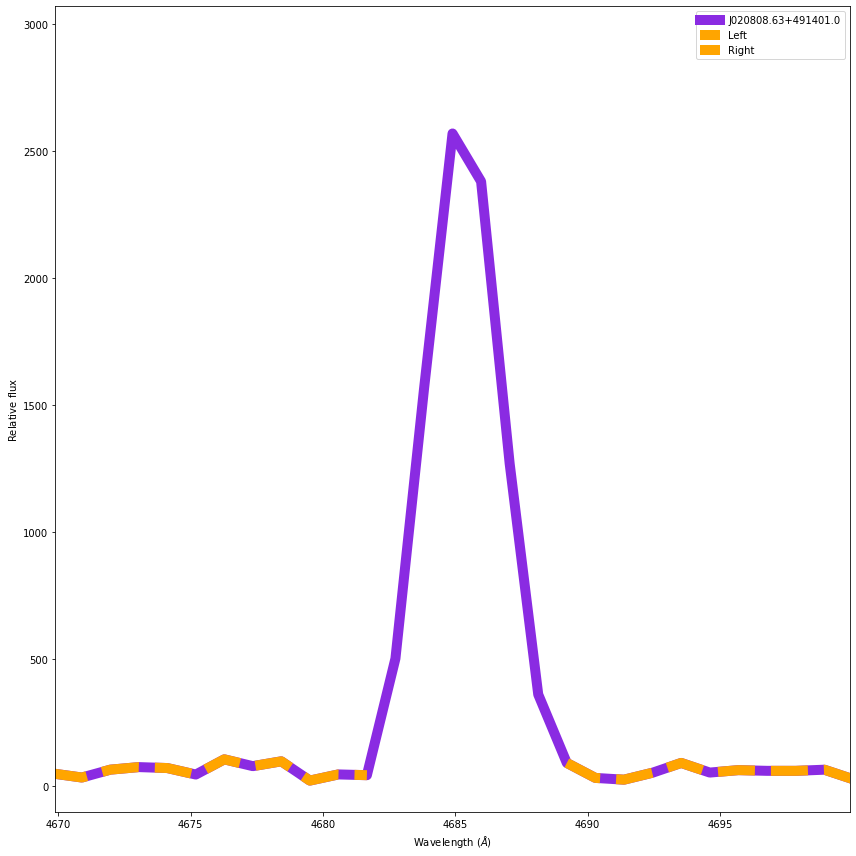

Number of line found: 5
Number of pixels: 3


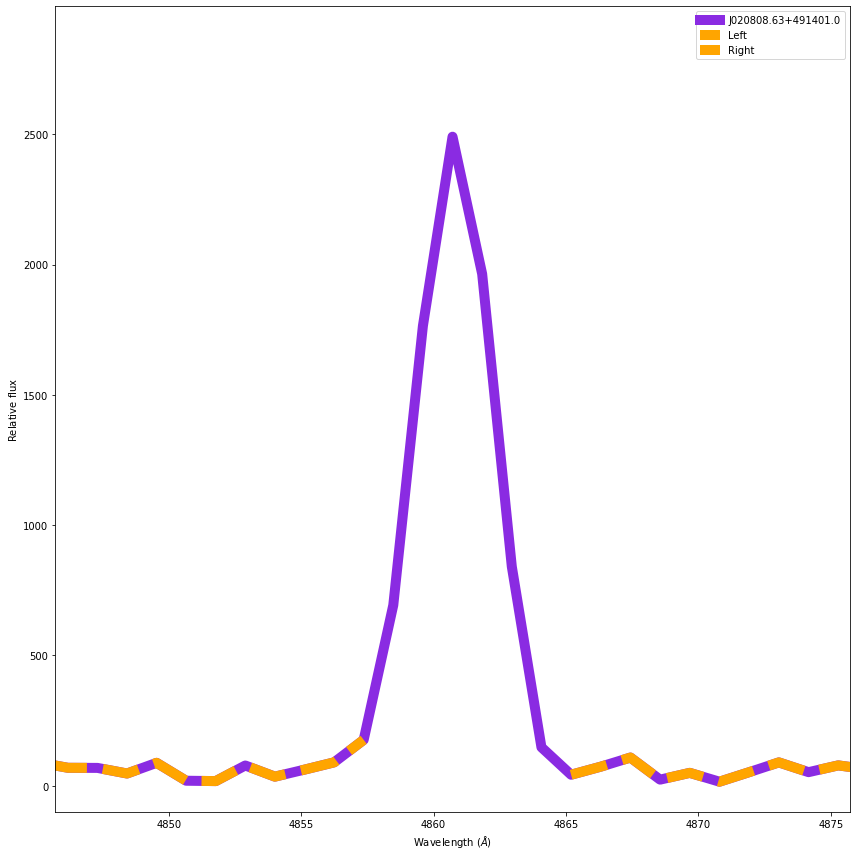

Number of line found: 1
Number of pixels: 3


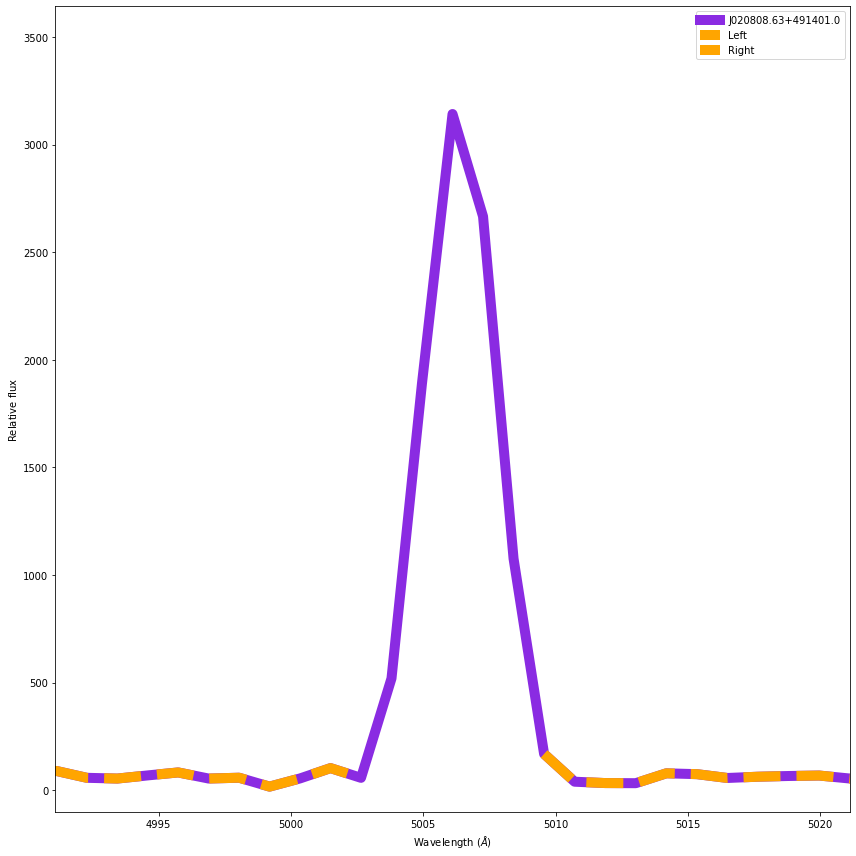

Number of line found: 1
Number of pixels: 3


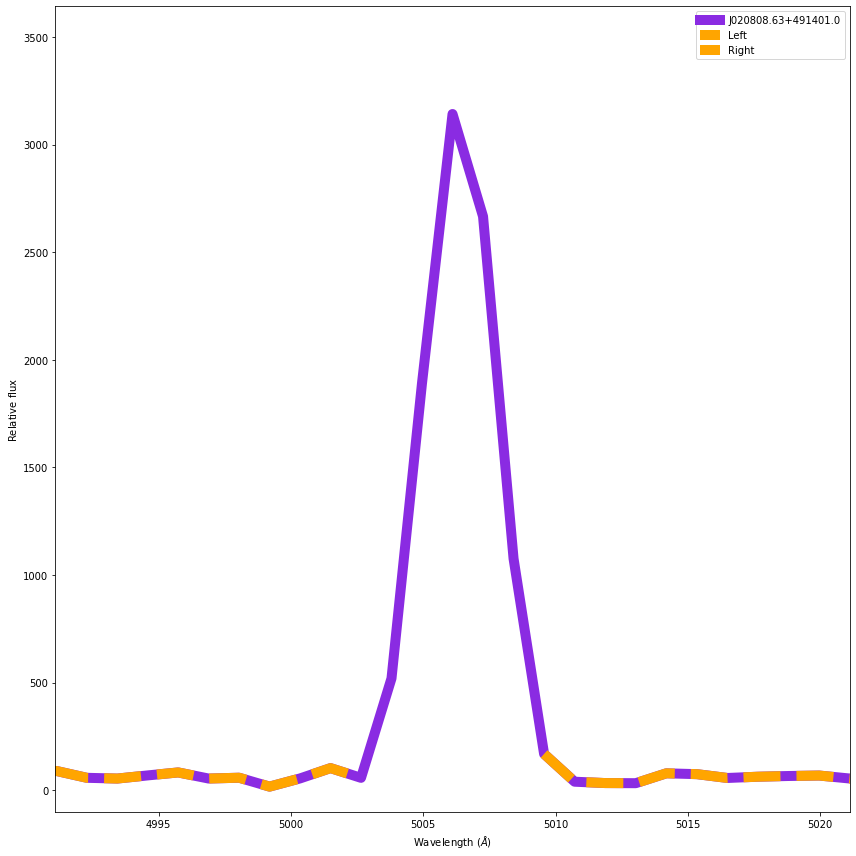

Number of line found: 1
Number of pixels: 3


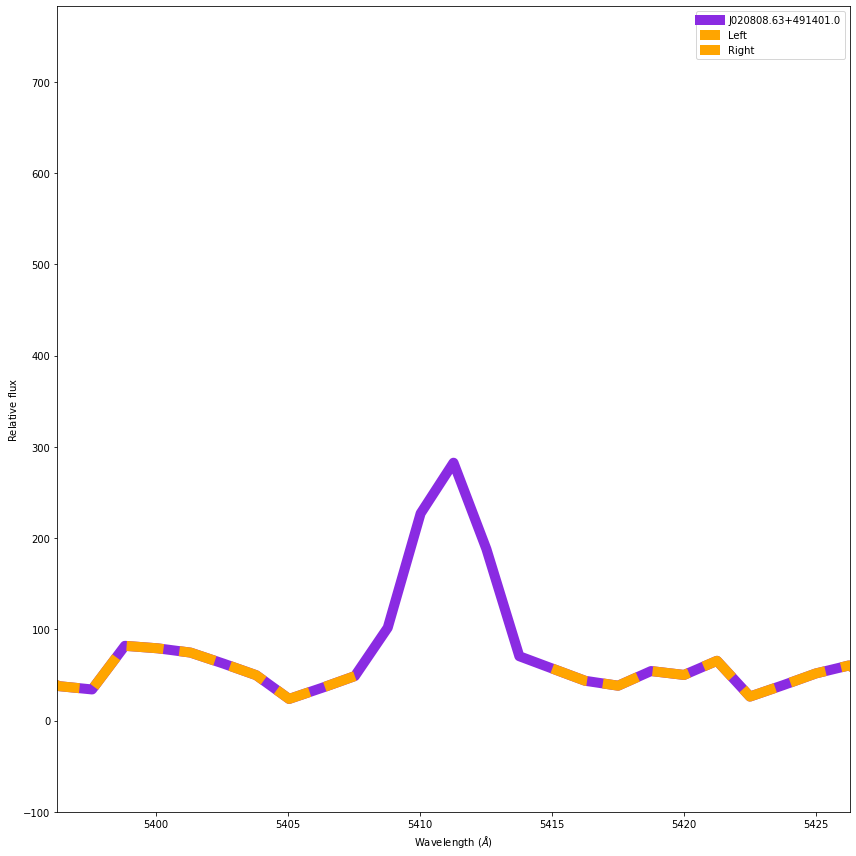

Number of line found: 1
Number of pixels: 2


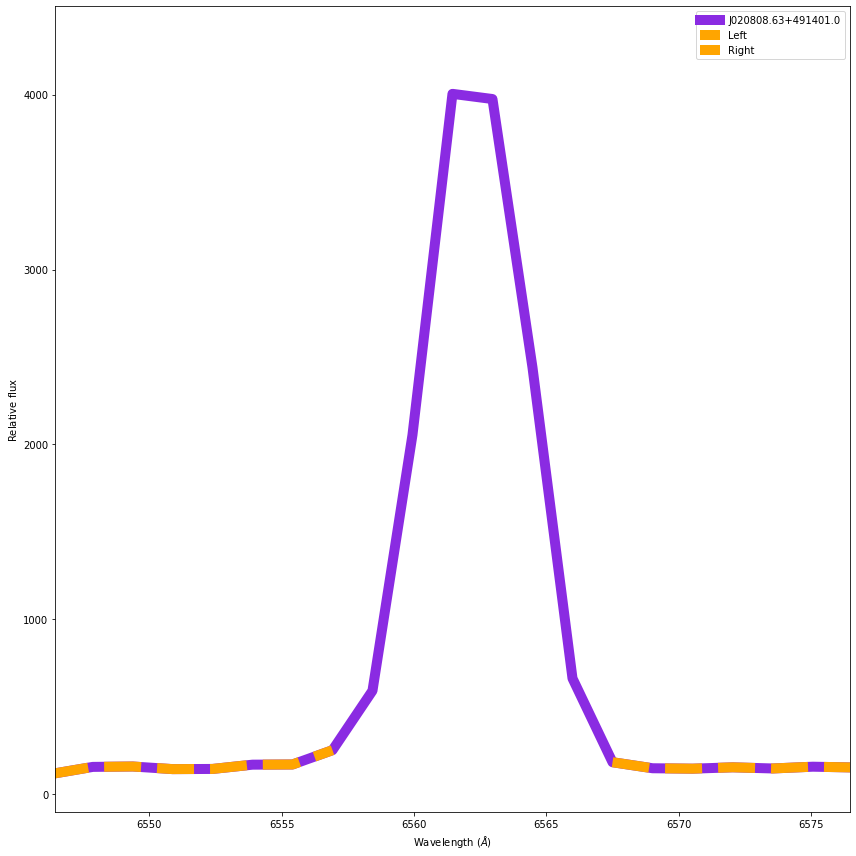

In [54]:
for vv, tt in lines.items():
    errcont(tt, spec)